# A comprehensive set of examples on how to use *yupi* library

**Yupi** is a set of tools designed for collecting, generating and processing trajectory data. It is written in Python, on top of state-of-the-art libraries for data and image processing, such as opencv, numpy and matplotlib. The focus of this tool is to bring a complete framework for handling trajectory data: covering artificial generation of trajectories using stochastic models, estimation of the motion of objects inside image sequences and statistical analysis of trajectories through different methods. 

This notebook is intended to showcase most of **yupi's** API using minimal code snippets for each functionality. For more complex examples on the integration of the individual functionalities you can check code available in: https://github.com/yupidevs/yupi_examples

## 1. Getting started

First let us make sure **yupi** is already installed, the next line should not raise any errors:

In [1]:
import yupi

<div class="alert alert-block alert-warning">
<b>ℹ️ Hint:</b> If you got a <i>ModuleNotFoundError</i>, the interpreter of python on wich you are running this notebook doesn't have <b>yupi</b> installed. To install it, follow the instructions on the <a href="https://yupi.readthedocs.io/en/latest/GS/Installation.html">Installation and compatibility</a> section in the package's official documentation. If you want to see a live version of this notebook without manually setting up python in your system you can do it <a href="https://mybinder.org/v2/gh/yupidevs/yupi_examples/HEAD">here</a>.
</div>

## 2. Handling trajectory data with *yupi*

**Yupi** stores data using an efficient internal representation of trajectories based on numpy arrays. This unfied representation is used accross the library. In this section we ilustrate how to handle creation, modification and storage trajectories.
 
### 2.1 Converting your data into Trajectory objects

If you already have some trajectory data, is possible to convert it into a **yupi** `Trajectory`. Next, we show how to create the same trajectory in different ways.

#### 2.1.1 Creating trajectories with *x*, *y* and *z* information

When the data belongs to trajectories of dimensions within 1 and 3, it is possible to create a `Trajectory` by assigning each axis data directly:


In [1]:
from yupi import Trajectory

x = [0, 1.0, 0.63, -0.37, -1.24, -1.5, -1.08, -0.19, 0.82, 1.63, 1.99, 1.85]
y = [0, 0, 0.98, 1.24, 0.69, -0.3, -1.23, -1.72, -1.63, -1.01, -0.06, 0.94]

traj1 = Trajectory(x=x, y=y, traj_id="Spiral")

For the three-dimensional case, you can pass a variable `z` to the constructor. If the trajectory has more than 4 dimensions, check the next methods for creating the object.


#### 2.1.2 Creating trajectories with independent axis information

An extension to the previous case, that can be useful for Trajectories of higher dimensions, is to provide all the axis information in a single variable. The following example shows how to proceed in this case:

In [3]:
from yupi import Trajectory

dims = [
   [0, 1.0, 0.63, -0.37, -1.24, -1.5, -1.08, -0.19, 0.82, 1.63, 1.99, 1.85],
   [0, 0, 0.98, 1.24, 0.69, -0.3, -1.23, -1.72, -1.63, -1.01, -0.06, 0.94]
]

traj2 = Trajectory(dimensions=dims, traj_id="Spiral")

#### 2.1.3 Creating trajectories with independent point samples

There is also a third way of convert your data into a Trajectory. It requires to pass a list of d-dimensional data points:

In [4]:
from yupi import Trajectory

points = [[0, 0], [1.0, 0], [0.63, 0.98], [-0.37, 1.24], [-1.24, 0.69],
          [-1.5, -0.3], [-1.08, -1.23], [-0.19, -1.72], [0.82, -1.63],
          [1.63, -1.01], [1.99, -0.06], [1.85, 0.94]]

traj3 = Trajectory(points=points, traj_id="Spiral")

Note that the dimension of each point must be equal, and it will define the dimension of the trajectory.

#### 2.1.4 A brief comment on time

By default, the data will be assumed to be uniformly sampled in time, at a sampling time of 1. If you have the corresponding sequence of time data, you can pass it to the constructor using the *t* parameter. Alternatively, if the data is uniformly sampled, you can only pass the value of *dt*.

### 2.2 Velocity estimation

In this tutorial the different velocity estimation method will be shown and tested. The user will learn how to change and configure these methods.

In [38]:
import numpy as np
from yupi import Trajectory, VelocityMethod, WindowType
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 5)

First, let's create three functions:

$$y_1(t) = t^2$$
$$y_2(t) = t^5 - 19t^3 + 25t^2 + 45t - 3$$
$$y_3(t) = \sin(t)$$

And their respective first derivative:

$$\frac{dy_1}{dt}(t) = 2t$$
$$\frac{dy_2}{dt}(t) = 5t^4 - 57t^2 + 50t + 45$$
$$\frac{dy_3}{dt}(t) = \cos(t)$$

In [39]:
t = np.linspace(-4, 4, 1000)

y1 = t ** 2
y2 = t ** 5 - 19 * t ** 3 + 25 * t ** 2 + 45 * t - 3
y3 = np.sin(t)

dy1 = 2 * t
dy2 = 5 * t ** 4 - 57 * t ** 2 + 50 * t + 45
dy3 = np.cos(t)

funcs = [y1, y2, y3]
derivs = [dy1, dy2, dy3]

Let's see how these functions and their derivatives look like

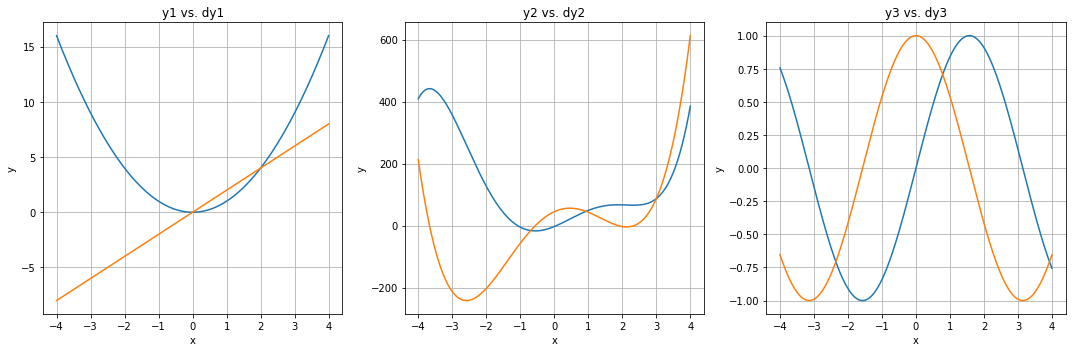

In [40]:
for i, func in enumerate(funcs):
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"y{f_id} vs. dy{f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, func)
    plt.plot(t, der)
plt.tight_layout()
plt.show()

If we think of $t$ as time and $y(t)$ a position at a given time, these functions can represent one dimensional trajectories.

In [41]:
def create_trajs(*args, time=None):
    time = t if time is None else time
    return [Trajectory(y, t=time) for y in args]

trajs = create_trajs(y1, y2, y3)

Knowing that the velocity is the position change rate with respect to the change of time ($\Delta x/\Delta t$), then the velocities of these trajectories should aproximate to the derivatives of the functions.

In **yupi** there are two principal velocity estimation methods: `LINEAR_DIFF` and `FORNBEGR_DIFF`, both based on the finte differences method. The `LINEAR_DIFF` method uses order one schemes to aproximate the derivative of a function. On the other hand, `FORNBERG_DIFF` method is based on the algorithm presented on (**CITA!!**). With this approach the derivative can be estimated with several order of accuracy (even if the data is not equally spaced). In both of this methods a window type can be specified (`FORWARD`, `BACKWARD`, `CENTRAL`). This parameter indicates whether the data for aproximating the derivative at an index $i$ is taken from the indices after, before or around $i$ respectively.

Trajectories in **yupi** use by default the `LINEAR_DIFF` method with a `CENTRAL` window type.

Let's compare estimated velocities from the previously created trajectories with the real values of the derivatives.

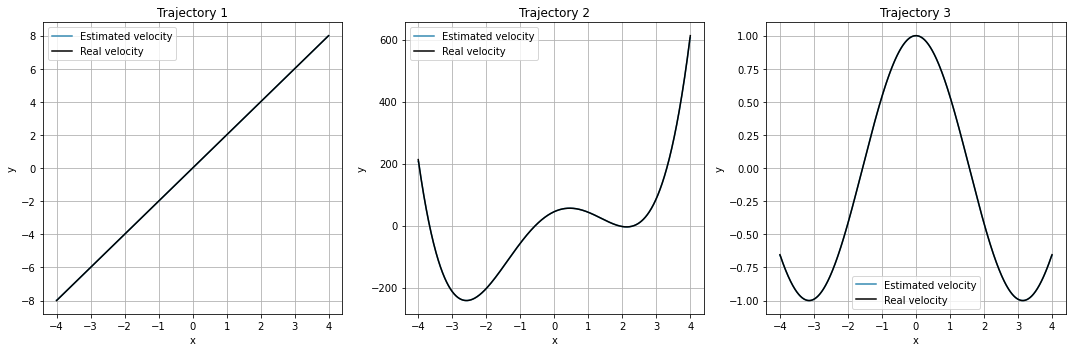

In [42]:
for i in range(3):
    traj = trajs[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, traj.v, color="#3489b1", label="Estimated velocity")
    plt.plot(t, der, "k", label="Real velocity")
    plt.legend()

plt.tight_layout()
plt.show()

They seems to be pretty accurate. But these are ideal cases, there is no noice in the data and the points are equally spaced (which is not the case in real life data usually).

#### 2.2.1 Testing with noicy data

Let's add some small gaussian noice to each of this values, create new trajectories with them, and check the velocity estimations.

In [43]:
np.random.seed(0)

noicy_y1 = y1 + np.random.normal(0, 0.002, len(y1))
noicy_y2 = y2 + np.random.normal(0, 0.20, len(y2))
noicy_y3 = y3 + np.random.normal(0, 0.002, len(y3))

noicy_funcs = [noicy_y1, noicy_y2, noicy_y3]

noicy_trajs = create_trajs(*noicy_funcs)

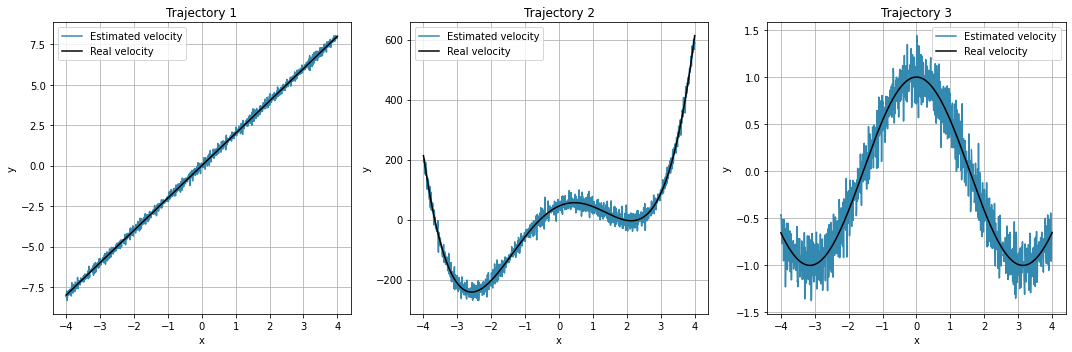

In [44]:
for i in range(3):
    traj = noicy_trajs[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, traj.v, color="#3489b1", label="Estimated velocity")
    plt.plot(t, der, "k", label="Real velocity")
    plt.legend()

plt.tight_layout()
plt.show()

One way for users to use another velocity aproximation method (or another parameter for the current method) is by the parameter `vel_est` of the trajectory constructor. This parameter recieve a dictionary with the wanted configuration. The possible keys are: `method`, `window_type` and `accuracy` wich defines the estimation method, the window type an the accuracy (this last is only valid if the method used is `FORNBERG_DIFF`). If one of the key is missing, the default value for that parameter will be assumed.

Let's create a new set of trajectories with the estmation method by default (`LINEAR_DIFF`) but this time using `FORWARD` window type, and compare the results.

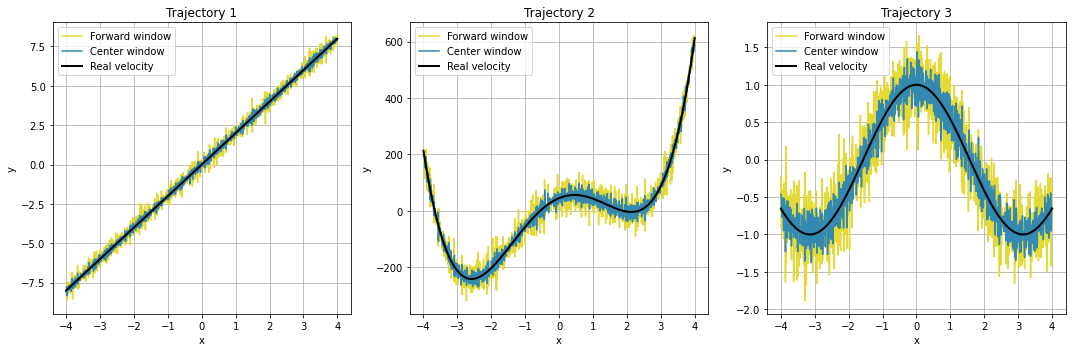

In [45]:
center_win_vels = [traj.v for traj in noicy_trajs]

forward_win_vels = [
    Trajectory(n, t=t, vel_est={"window_type": WindowType.FORWARD}).v for n in noicy_funcs
]

for i in range(3):
    center_win_vel = center_win_vels[i]
    forward_win_vel = forward_win_vels[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, forward_win_vel, color="#e5d935", label="Forward window")
    plt.plot(t, center_win_vel, color="#3489b1", label="Center window")
    plt.plot(t, der, "k", label="Real velocity", linewidth=2)
    plt.legend()

plt.tight_layout()
plt.show()

As we can see in the charts, using a `CENTRAL` window type gives us a better aproximation than using the `FORWARD` type. Let's test also the `FORNBERG_DIFF` method with a `CENTRAL` window type and a 4 level of accuracy (accuracy in `FORNBERG_DIFF` method must be always even if the window type is `CENTRAL`).

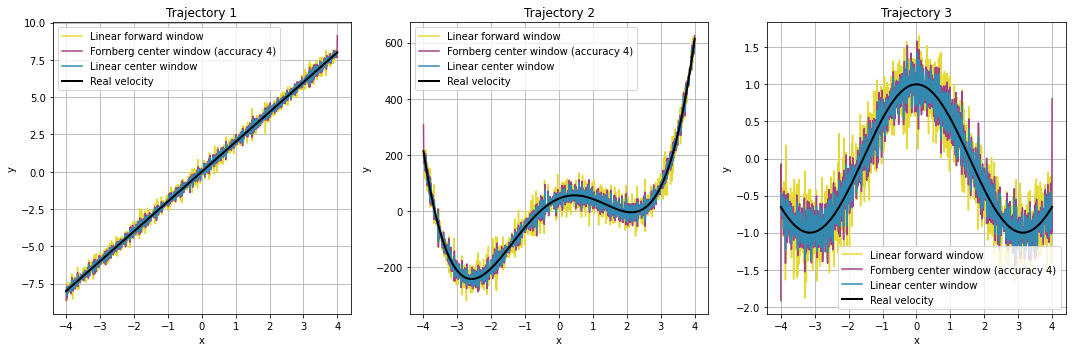

In [46]:
vel_est = {
    "method": VelocityMethod.FORNBERG_DIFF,
    "window_type": WindowType.CENTRAL,
    "accuracy": 4
}

est_vels = [Trajectory(n, t=t, vel_est=vel_est).v for n in noicy_funcs]

for i in range(3):
    center_win_vel = center_win_vels[i]
    forward_win_vel = forward_win_vels[i]
    est_vel = est_vels[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(t, forward_win_vel, color="#e5d935", label="Linear forward window")
    plt.plot(t, est_vel, color="#a14383", label="Fornberg center window (accuracy 4)")
    plt.plot(t, center_win_vel, color="#3489b1", label="Linear center window")
    plt.plot(t, der, "k", label="Real velocity", linewidth=2)
    plt.legend()

plt.tight_layout()
plt.show()

#### 2.2.2 Testing with non equally spaced data

Sometimes the trajectory data may be not equally spaced. In these cases traditional higer-order of accuracy derivation methods can't be use (there is no fixed $\Delta t$). For these cases, the `FORNBERG_DIFF` method can be used if the level of accuracy needs to be higher than 1. This level can be specified as mentioned before with the parameter `accuracy`.

Let's subsample in a non uniform way the current data and create a new set of trajectories.

In [47]:
indexes = np.sort(np.random.choice(range(len(t)), size=200, replace=False))
nes_t = t[indexes]  # Non equal spaced (nes)

nes_funcs = [y1[indexes], y2[indexes], y3[indexes]]
nes_trajs = create_trajs(*nes_funcs, time=nes_t)

There are two other forms for changing the velocity estimation configuration. If the trajectory is already created the instance functon `set_vel_method` can be use to achieve this as shown below.

If the default configuration wants to be modify, the static method `global_vel_method` can be used. This will affect all the trajectories created after.

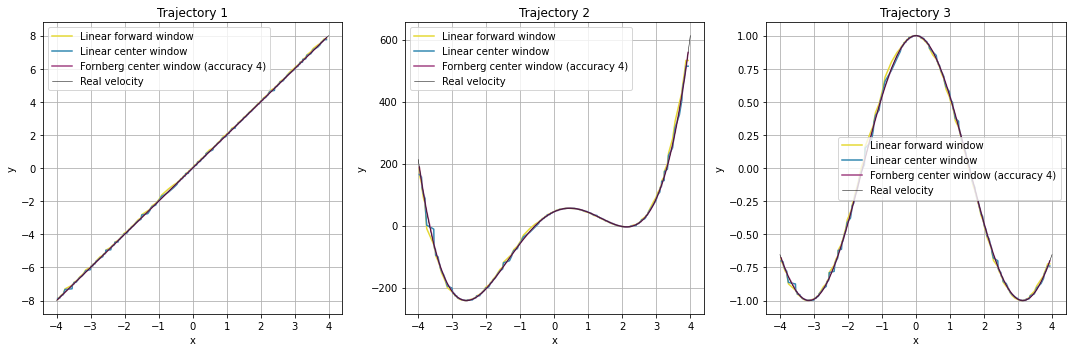

In [48]:
nes_center_win_vels = [traj.v for traj in nes_trajs]

nes_forward_win_vels = [traj.copy() for traj in nes_trajs]
for traj in nes_forward_win_vels:
    # Change the velocity estimation for a created trajectory
    traj.set_vel_method(
        method=VelocityMethod.LINEAR_DIFF,
        window_type=WindowType.FORWARD,
    )
nes_forward_win_vels = [traj.v for traj in nes_forward_win_vels]

# Change the global velocity estimation used as default
Trajectory.global_vel_method(
    method=VelocityMethod.FORNBERG_DIFF,
    window_type=WindowType.CENTRAL,
    accuracy=4
)
nes_est_vels = [Trajectory(n, t=nes_t).v for n in nes_funcs]

Trajectory.global_vel_method(
    method=VelocityMethod.LINEAR_DIFF,
    window_type=WindowType.CENTRAL,
)

for i in range(3):
    center_win_vel = nes_center_win_vels[i]
    forward_win_vel = nes_forward_win_vels[i]
    est_vel = nes_est_vels[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.plot(nes_t, forward_win_vel, color="#e5d935", label="Linear forward window")
    plt.plot(nes_t, center_win_vel, color="#3489b1", label="Linear center window")
    plt.plot(nes_t, est_vel, color="#a14383", label="Fornberg center window (accuracy 4)")
    plt.plot(t, der, "k", label="Real velocity", linewidth=.5)
    plt.legend()

plt.tight_layout()
plt.show()

Although these are more accurate aproximations, the results show some visible irregularities in the estimations. As it is hard to compare the different configurations in these charts, let's check the absolute difference between the estimation and the real values.

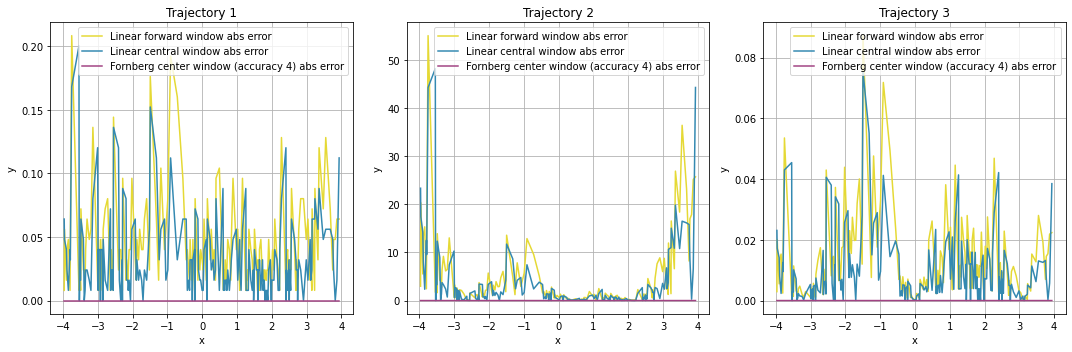

In [49]:
for i in range(3):
    center_win_vel = nes_center_win_vels[i]
    forward_win_vel = nes_forward_win_vels[i]
    est_vel = nes_est_vels[i]
    der = derivs[i]
    f_id = i + 1
    plt.subplot(130 + f_id)
    plt.title(f"Trajectory {f_id}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    err_1 = np.abs(forward_win_vel[:, 0] - der[indexes])
    err_2 = np.abs(center_win_vel[:, 0] - der[indexes])
    err_3 = np.abs(est_vel[:, 0] - der[indexes])
    plt.plot(nes_t, err_1, color="#e5d935", label="Linear forward window abs error")
    plt.plot(nes_t, err_2, color="#3489b1", label="Linear central window abs error")
    plt.plot(nes_t, err_3, color="#a14383", label="Fornberg center window (accuracy 4) abs error")
    plt.legend()

plt.tight_layout()
plt.show()

As the charts show, the `FORNBERG_DIFF` method is astonishing much accurate that the other methods in this case.

The previous examples show there is no "better" method for estimating the velocitiy, it depends on the data and the user needs. This is the prncipal reason yupi offers two principal methods with adjustable parameters and easy configurations.

### 2.3 Operations on Trajectory objects

Let us consider a simple 2D trajectory:

In [5]:
traj = Trajectory(points=[[1,2], [3,3], [4,2]])

There are several ways a trajectory can be modified in **yupi**.

#### 2.3.1 Shifting

If the trajectory needs to be shifted it can be done by adding (or substracting) a tuple (or any array-like structure) with the same dimensions of the trajectory points:

In [18]:
transf_traj = traj + (1, 4)
centered = traj - traj.r[0]
print(f"Shifted trajectory points: \n{transf_traj.r}\n")
print(f"Centered trajectory points: \n{centered.r}\n")

Shifted trajectory points: 
[[2. 6.]
 [4. 7.]
 [5. 6.]]

Centered trajectory points: 
[[0. 0.]
 [2. 1.]
 [3. 0.]]



Both operations can be made in-place when using the operators: `+=` or `-=`.
    
#### 2.3.2 Scaling

Spatial scaling of a trajectory can be also achieved by multiplying it by a constant:

In [19]:
scaled_traj = traj * 3
print(f"Scaled trajectory points: \n{scaled_traj.r}\n")

Scaled trajectory points: 
[[ 3.  6.]
 [ 9.  9.]
 [12.  6.]]



This operation can be made in-place when using the operator `*=`.

#### 2.3.3 Rotation

Rotation can be made using the `rotate2d()` method:

In [25]:
import numpy as np
traj_2 = Trajectory(points=[[0,0], [1,0], [2,0]])
print(f"Original trajectory points: \n{np.round(traj_2.r, 2)}\n")
traj_2.rotate2d(np.pi / 2)
print(f"Rotated trajectory points: \n{np.round(traj_2.r, 2)}\n")

Original trajectory points: 
[[0. 0.]
 [1. 0.]
 [2. 0.]]

Rotated trajectory points: 
[[0. 0.]
 [0. 1.]
 [0. 2.]]



#### 2.3.4 Indexing and slicing

Trajectory objects can also be indexing and obtain the i-th TrajectoryPoint:

In [9]:
traj = Trajectory(points=[[1,2], [3,3], [4,2]])
p2 = traj[2]   # p2.r = [4,2]

Slicing is possible too and it is used to obtain a subtrajectory. All variance of slicing in python are possible:

In [29]:
traj = Trajectory(points=[[1,2], [3,3], [4,2], [4,1], [2,7]])
sub_traj_1 = traj[2:]    # sub_traj_1.r = [[4,2], [4,1], [2,7]]
sub_traj_2 = traj[:-1]   # sub_traj_2.r = [[1,2], [3,3], [4,2], [4,1]]
sub_traj_3 = traj[1:4]   # sub_traj_3.r = [[4,2], [4,1]]

#### 2.3.5 Filtering

Trajectory objects can be filtered in different ways. By default, **yupi** offers an Exponential Convolutional Filter, typically used in the context of animal trajectory analysis:

In [11]:
from yupi.transformations import exp_convolutional_filter
traj = Trajectory(points=[[1,2], [3,3], [4,2]])
smoothed_traj = exp_convolutional_filter(traj, 1)

#### 2.3.6 Adding and subtracting

If two trajectories have the same length and dimensions they can be added or subtracted by:

In [31]:
traj_a = Trajectory(points=[[1,2], [3,3], [4,2]])
traj_b = Trajectory(points=[[0,0], [1,4], [2,3]])
traj_c = traj_a + traj_b

print(f"Resulting trajectory points: \n{traj_c.r}\n")

Resulting trajectory points: 
[[1. 2.]
 [4. 7.]
 [6. 5.]]



### 2.4 Storage of Trajectory objects

Regardless the source of the Trajectory object, you can store it on disk and later load it for further processing or analysis.

#### 2.4.1 Writing Trajectory objects

To store your Trajectory object, (e.g. any of the ones created in the previous tutorials) you only need to call the save() method as in:

In [32]:
traj_a.save('spiral', file_type='json')

This will produce a json file with all the details of the object that can be loaded anytime using **yupi**. Additionally, `csv` is another `file_type` available to store `Trajectory` objects.

#### 2.4.2 Reading Trajectory objects

To `load()` a previously written `Trajectory` object:

In [14]:
from yupi import Trajectory
traj_a = Trajectory.load('spiral.json')


## 3. Generating artificial Trajectory objects

If you want to generate `Trajectory` objects based on some statistical constrains, you can use one of the available `Generator` to construct a list of Trajectory objects.

To generate a collection of trajectories with **yupi**, despite the nature of the generator chosen, we can specify four parameters that characterize numerical properties of the generated trajectories:

In [34]:
T = 500     # Total time (number of time steps if dt==1)
dim = 2     # Dimension of the walker trajectories
N = 3       # Number of random walkers
dt = 1      # Time step


### 3.1 Random Walk Generator

The `RandomWalkGenerator` is able to simulate the trajectories of a walker, in an arbitrary number of dimensions, according some probabilistic constrains.

In [35]:
from yupi.generators import RandomWalkGenerator

The `RandomWalkGenerator` starts the generation of every trajectory in the origin of the reference frame. Then, iteratively, it computes an increment on each dimension. The increment (also called actions) can be -1, 0 or 1, and it is taken independently on each dimension for each iteration. Additionally, the user can define a list to establish the probabilities of taking each of the available actions:

In [36]:
prob = [[.5, .1, .4],   # x-axis
        [.5,  0, .5]]   # y-axis

Notice that the size of this list should coincide with the desired dimensions of the trajectories being generated, and each element of a list should be a 3-element list describing the probability vector of taking the actions `[-1, 0, 1]` in that dimension.

Then, we can construct a `RandomWalkGenerator` with the given variables and call its `generate()` method:

In [37]:
rw = RandomWalkGenerator(T, dim, N, dt, prob)
tr = rw.generate()

In the variable `tr` we will have a list of `N` `Trajectory` objects generated using the given configuration.

The generated trajectories can be inspected using the `plot_2D()` function:

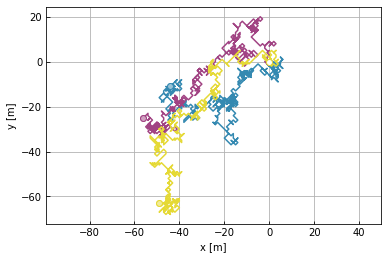

In [38]:
from yupi.graphics import plot_2D
plot_2D(tr, legend=None)

### 3.2 Langevin Generator

The LangevinGenerator simulates trajectories governed by the Langevin Equation. It allows to produce Trajectory objects that quantitatively emulate several systems.

To use it, we first need to define the general parameters for a generator:

In [20]:
T = 500     # Total time (number of time steps if dt==1)
dim = 2     # Dimension of the walker trajectories
N = 3       # Number of random walkers
dt = 0.5    # Time step

Then, some specific parameters can be set before the generator initialization:

In [21]:
tau = 1               # Relaxation time
sigma = 0.1     # Scale of the noise pdf

Finally, the generator is created and the trajectories can be generated:

In [22]:
from yupi.generators import LangevinGenerator
lg = LangevinGenerator(T, dim, N, dt, tau, sigma)
trajectories = lg.generate()

The generated trajectories can be inspected using the plot_2D function:

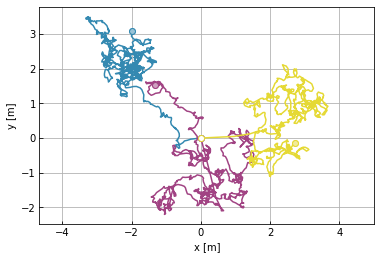

In [23]:
from yupi.graphics import plot_2D
plot_2D(trajectories, legend=None)

Although not illustrated in this example, the initial velocities and positions can be specified in the LangevinGenerator creation using the v0 and r0 parameters respectively.

A more complex application of this Generator can be seen in the Example 1.

### 5.3 Diffusing Diffusivity Generator

The DiffDiffGenerator simulates trajectories governed by a diffusion process with fluctuating diffusivity. It allows to produce Trajectory objects that quantitatively emulate different systems.

To use it, we first need to define the general parameters for a generator:

In [24]:
T = 1000   # Total time of the simulation
N = 5      # Number of trajectories
dt = .1    # Time step
dim = 2    # Dimension of the Trajectories

The generator is created and the trajectories can be generated:

In [25]:
from yupi.generators import DiffDiffGenerator
dd = DiffDiffGenerator(T, N=N, dt=dt, dim=dim)
trajs = dd.generate()

The generated trajectories can be inspected using the plot_2D function:

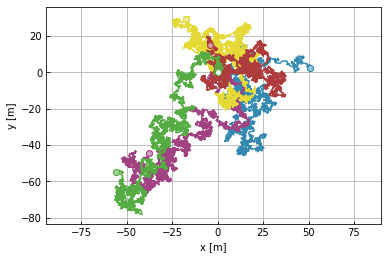

In [26]:
from yupi.graphics import plot_2D
plot_2D(trajs, legend=None)

Although not illustrated in this example, the initial positions can be specified in the DiffDiffGenerator creation using the r0 parameter.

### 5.4 Defining a Custom Generator

A user-defined generator can be easily added by building on top of an abstract class Generator (which is the base of the already implemented generators).

## 6. Extracting data from an ensemble of trajectories

Collecting data such as displacements, velocities, speeds is a common task when analyzing trajectory data. Therefore, looping over an ensemble of trajectories ends up in repeated blocks of code specially when the data is wanted to, for instance, be analyzed at different time scales or be concatenated.

This tutorial provides an step-by-step view over the collect() function. It gets a friendly way to “collect” the basic time series researchers that process trajectories are continuously dealing with.

Let us first create a fake ensemble of just two (for the sake of illustration) trajectories using the Trajectory class from yupi.

In [27]:
import numpy as np
from yupi import Trajectory
from yupi.stats import collect

# x-coordinate for the first/second trajectory
x1 = 2 * np.arange(5)
x2 = x1 + 1

# y-coordinates
y1 = x1**2
y2 = x2**2

# Time step and ids
dt = .5
id_traj1 = 'traj_01'
id_traj2 = 'traj_02'

# Instantiating the class
traj1 = Trajectory(x=x1, y=y1, dt=dt, traj_id=id_traj1)
traj2 = Trajectory(x=x2, y=y2, dt=dt, traj_id=id_traj2)

# Gather in an ensemble
trajs = [traj1, traj2]

At this point, it is quite easy using yupi to extract some time series from a single trajectory. For example:

* **position:** traj1.r
* **displacement:** traj1.r.delta
* **velocity:** traj1.v
* **speed:** traj1.v.norm
* **distance:** traj1.delta_r.norm

But how to get these from an ensemble? How to extract it when time scales are different from the time step? In what is next, these questions are answered with some illustrative examples while a detailed explanation of every parameter is given on the collect() function.

### 6.1 Collect general function

By default, the collect() function takes a list trajectory an returns an array with all the positional data of each trajectory concatenated.

collect(trajs)

array([[ 0.  0.]
       [ 2.  4.]
       [ 4. 16.]
       [ 6. 36.]
       [ 8. 64.]
       [ 1.  1.]
       [ 3.  9.]
       [ 5. 25.]
       [ 7. 49.]
       [ 9. 81.]])

The following sections will describe all the parameters available that manipulate the resulting data within the collect() function.

### 6.2 The lag parameter

Suppose the underlying ensemble of trajectories as being realizations of a process with different statistical properties at different time scales. For such a case, lag can be helpful if it is set properly. If lag is an integer it is taken as the number of samples. On the other hand, if lag is of type float, it is taken as the time to lag where its units are those of the time array (i.e., traj.t).

If lag is not set, the default value is lag=0 will be assumed.

collect(trajs, lag=2)

array([[ 4., 16.],
       [ 4., 32.],
       [ 4., 48.],
       [ 4., 24.],
       [ 4., 40.],
       [ 4., 56.]])

collect(trajs, lag=1.0)

array([[ 4., 16.],
       [ 4., 32.],
       [ 4., 48.],
       [ 4., 24.],
       [ 4., 40.],
       [ 4., 56.]])

The concat parameter

As we show in the very first example, the code for concat(trajs) will return an array with all the positional data of each trajectory concatenated.

If the data is wanted to be split by realizations, the concat parameter should be set to False.

collect(trajs, concat=False)

array([[[ 0.,  0.],
        [ 2.,  4.],
        [ 4., 16.],
        [ 6., 36.],
        [ 8., 64.]],

       [[ 1.,  1.],
        [ 3.,  9.],
        [ 5., 25.],
        [ 7., 49.],
        [ 9., 81.]]])

The warnings parameter

If the given lag is larger than one of the trajectories length, a warning message will arise and the position of the trajectory in the ensemble and its id will be shown. The collect() function will skip this trajectory. To avoid warning messages set the parameter to False.

traj1.dt = .01  # redefining dt for the first trajectory
collect(trajs, lag=dt)

15:07:11 [WARNING] Trajectory 0 with id=traj_01 is shorten than 50 samples
array([[ 2.,  8.],
       [ 2., 16.],
       [ 2., 24.],
       [ 2., 32.]])

collect(trajs, lag=dt, warnings=False)

array([[ 2.,  8.],
       [ 2., 16.],
       [ 2., 24.],
       [ 2., 32.]])

The velocity parameter

Some times it is useful to have the velocity of the trajectory. To indicate that the velocity is wanted, the velocity parameter should be set to True.

collect(trajs, velocity=True)

array([[ 4.  8.]
       [ 4. 24.]
       [ 4. 40.]
       [ 4. 56.]
       [ 4. 16.]
       [ 4. 32.]
       [ 4. 48.]
       [ 4. 64.]])

Additional if the lag is used, the velocity will be calculated according the given lag.

collect(trajs, lag=2, velocity=True)

array([[ 4. 16.]
       [ 4. 32.]
       [ 4. 48.]
       [ 4. 24.]
       [ 4. 40.]
       [ 4. 56.]])

The func parameter

All the examples described above only returns raw data from the trajectories. If the data is wanted to be transformed, the func parameter should be set to a function that will be applied to each vector (before concatenation).

This could help if we want to extract for example the delta velocity of the trajectories.

collect(trajs, velocity=True, func=lambda vec: vec.delta)

array([[ 0. 16.]
       [ 0. 16.]
       [ 0. 16.]
       [ 0. 16.]
       [ 0. 16.]
       [ 0. 16.]])

collect(trajs, func=lambda vec: vec.norm)

array([ 4.47213595 12.16552506 20.09975124 28.0713377 8.24621125 16.1245155
       24.08318916 32.06243908])

The at parameter

When the data is wanted to be extracted at a certain time (or index), the at parameter should be used. If at is an integer, it is taken as the index. If at is a float, it is taken as the time (in this case the index is calculated using the trajectory’s dt value).

This paramenter can not be used with lag parameter at the same time. In addition, When the at parameter is used, the concat parameter is ignored.

collect(trajs, at=1)

array([[ 2.,  4.],
       [ 3.,  9.]])

collect(trajs, at=.5)

array([[ 2.,  4.],
       [ 3.,  9.]])

Collect specific functions

    collect_at_step()

    collect_at_time()

    collect_step_lagged()

    collect_time_lagged()

These functions are just spetializations of the collect() function. All of them use the collect() function internally. Each of them has a different usage depending on if the data is wanted to be extracted at a certain time or step or if it is wanted to be extracted lagged.

## 7. Statistical Analysis of Trajectory objects

There are several tools you can use to analyze Trajectory objects. To illustrate the capabilities of yupi, let us consider a list of Trajectory objects generated with a Langevin Generator (See tutorial dedicated tutorial of Langevin Generator for a more detailed explanation of the parameters.)

In [28]:
from yupi.generators import LangevinGenerator
lg = LangevinGenerator(500, 2, 500, 0.5, 2,  0.1)
trajs = lg.generate()

### 7.1 Two-dimensional spatial projections

The most basic analysis tool is the plot of the trajectories in the space. If you have a list of Trajectory objects, like the ones you get from a generator, you can plot them with:

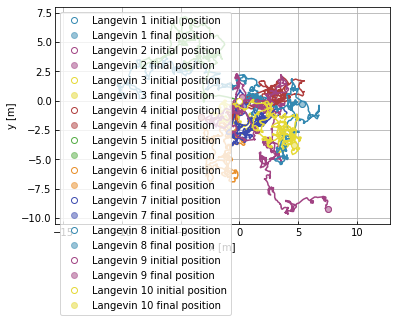

In [29]:
from yupi.graphics import plot_2D
plot_2D(trajs[:10])

Notice that we limited to 10 the number of trajectories to plot for the sake of observability, but we will be using the full list of trajectories (traj) all over this tutorial.

### Three-dimensional spatial projections

Plotting in three dimensions can be achieved in a similar way. Let us generate 3D trajectories:

In [30]:
from yupi.generators import LangevinGenerator
lg = LangevinGenerator(500, 3, 5, 0.5, 2,  0.1)
trajs3D = lg.generate()

Then, we can plot them using:

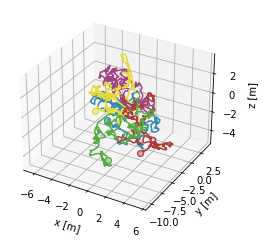

In [31]:
from yupi.graphics import plot_3D
plot_3D(trajs3D, show=True, legend=False)

### Histogram of Velocity

The analysis of the distribution of velocities among all the samples of an ensemble of trajectories is also possible using:

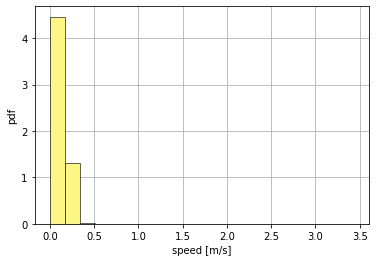

In [32]:
from yupi.stats import speed_ensemble
from yupi.graphics import plot_velocity_hist

v = speed_ensemble(trajs, step=1)
plot_velocity_hist(v, bins=20)

### Histogram of Turning Angles

The analysis of the distribution of turning angles allows to understand how likely is the moving object to turn to specific directions during its motion. It can be observe with yupi by using:

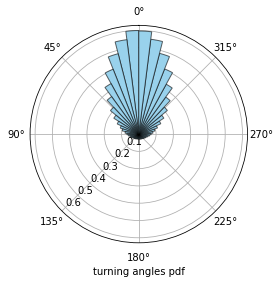

In [33]:
from yupi.stats import turning_angles_ensemble
from yupi.graphics import plot_angles_hist

theta = turning_angles_ensemble(trajs)
plot_angles_hist(theta, bins=50)

### Mean Squared Displacement

The Mean Square Displacement (MSD) is a typical indicator to classify processes away from normal diffusion. The MSD of a normal diffusive trajectory arises as a linear function of time. To estimate the MSD of a list of Trajectory objects, you can use:

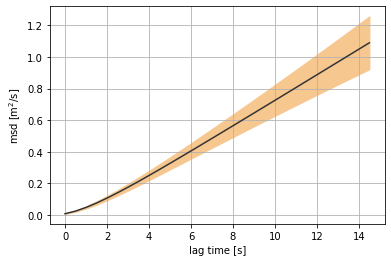

In [34]:
from yupi.stats import msd
from yupi.graphics import plot_msd

msd, msd_std = msd(trajs, time_avg=True, lag=30)
plot_msd(msd, msd_std, dt, lag=30)

### Kurtosis

Another useful quantity is the kurtosis, $kappa$, a measure of the disparity of spatial scales of a dispersal process and also an intuitive means to understand normality. It can be estimated using:

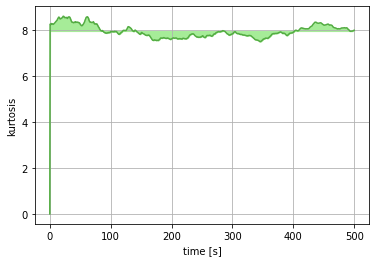

In [35]:
from yupi.stats import kurtosis, kurtosis_reference
from yupi.graphics import plot_kurtosis

ref = yupi.stats.kurtosis_reference(trajs)
kurtosis, _ = yupi.stats.kurtosis(trajs, time_avg=False, lag=30)
yupi.graphics.plot_kurtosis(kurtosis, kurtosis_ref=ref, dt=dt)

### Velocity Autocorrelation Function

The Velocity Autocorrelation Function (VACF) gives valuable information about the influence of correlations during a whole trajectory. To compute it and plot the results, you can use:

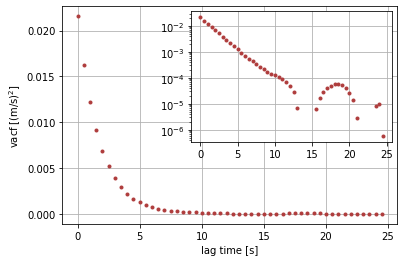

In [36]:
from yupi.stats import vacf
from yupi.graphics import plot_vacf

vacf, _ = vacf(trajs, time_avg=True, lag=50)
plot_vacf(vacf, dt, 50)

### Power Spectral Density

The Power Spectral Density, or Power Spectrum, indicates the frequency content of the trajectory. The inspection of the PSD from a collection of trajectories enables the characterization of the motion in terms of the frequency components.

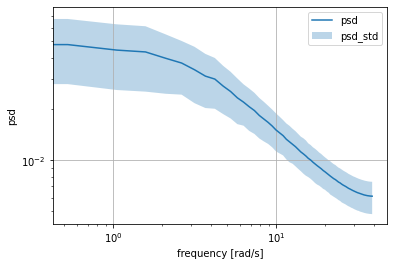

In [37]:
from yupi.stats import psd
from yupi.graphics import plot_psd

psd_mean, psd_std, omega = psd(trajs, lag=150, omega=True)
plot_psd(psd_mean, omega, psd_std)